# MNIST VAE with enumeration of discrete latent variable

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import numpy as np
import os
import torch
import torchvision
import torchvision.transforms as tvt
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO #, TraceGraph_ELBO
from pyro.optim import Adam, Adamax, Adadelta, SGD
from torchvision import utils
from matplotlib.pyplot import imshow
from torch.distributions import constraints

### Helper function

In [2]:
def show_batch(images,nrow=4,npadding=10):
    """Visualize a torch tensor of shape: (batch x ch x width x height) """
    batch, ch, width, height = images.shape
    if(images.device != "cpu"):
        images=images.cpu()
    grid = utils.make_grid(images,nrow, npadding, normalize=True, range=None, scale_each=True, pad_value=1)       
    imshow(grid.detach().numpy().transpose((1, 2, 0))) 
    
def train_one_epoch(svi, dataloader, verbose=False):
    epoch_loss = 0.
    n = 0
    for i, data in enumerate(dataloader, 0): #loop over minibatches
            
        # Get images and flatten them into vectors
        imgs,labels= data
        n += len(labels)
        if torch.cuda.is_available():
            imgs=imgs.cuda()
            
        loss = svi.step(imgs)
        
        if(verbose):
            print("i= %3d train_loss=%.5f" %(i,loss))
        epoch_loss += loss

    return epoch_loss / n

def evaluate_one_epoch(svi, dataloader, verbose=False):
    epoch_loss = 0.
    n = 0
    for i, data in enumerate(dataloader, 0): #loop over minibatches
            
        # Get images and flatten them into vectors
        imgs,labels= data
        n += len(labels)
        if torch.cuda.is_available():
            imgs=imgs.cuda()
        
        loss = svi.evaluate_loss(imgs)
        
        if(verbose):
            print("i= %3d  test_loss=%.5f" %(i,loss))
        epoch_loss += loss

    return epoch_loss / n

def save_obj(obj,root_dir,name):
    with open(root_dir + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(root_dir,name):
    with open(root_dir + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def save_model(model, root_dir, name):
    full_file_path= root_dir + name + '.pkl'
    torch.save(model.state_dict(),full_file_path)
    
def load_model(model, root_dir, name):
    full_file_path= root_dir + name + '.pkl'
    model.load_state_dict(torch.load(full_file_path))

### Define the simulation parameters

In [3]:
params = { 
    'K' : 10, #number of clusters
    'SCALE' : 1,
    'CHANNELS' : 1,
    'WIDTH' : 28,
    'HEIGHT':28,
    'Z_DIM':2,
    'use_cuda' : torch.cuda.is_available()
    }
print(params)

{'K': 10, 'SCALE': 1, 'CHANNELS': 1, 'WIDTH': 28, 'HEIGHT': 28, 'Z_DIM': 2, 'use_cuda': True}


### Get the data

torch.Size([512, 1, 28, 28])


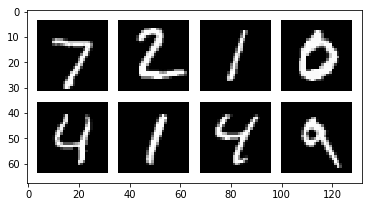

In [4]:
BATCH_SIZE = 512
kwargs = {'num_workers': 8, 'pin_memory': params["use_cuda"]}

trainset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=tvt.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
testset = torchvision.datasets.MNIST('./data', train=False, download=True, transform=tvt.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

imgs,labels = next(iter(testloader))

print(imgs.shape)
show_batch(imgs[:8],npadding=4)

### Define the VAE class

In [5]:
class ENCODER(torch.nn.Module):
    """ x -> p,dz """
    
    def __init__(self, params):
        super().__init__()
        self.K      = params['K']
        self.ch     = params['CHANNELS']
        self.width  = params['WIDTH']
        self.height = params['HEIGHT']
        self.z_dim  = params['Z_DIM']
        self.x_dim = self.ch*self.width*self.height
        self.intermediate  = torch.nn.Sequential(
            torch.nn.Linear(self.x_dim,100, bias=True),
            torch.nn.ReLU()
        )
        
        self.comp_p = torch.nn.Linear(100,self.K, bias=True)
        self.comp_dz = torch.nn.Linear(100,self.z_dim, bias=True)
        
            
        self.softmax = torch.nn.Softmax(dim=-1)
        self.tanh = torch.nn.Tanh()

    def forward(self,x):
        batch_size = x.shape[0]
        x1 = x.view(batch_size,-1)
        x2 = self.intermediate(x1)
        p = self.softmax(self.comp_p(x2))
        dz = self.tanh(self.comp_dz(x2))
        return p,dz
    
class DECODER(torch.nn.Module):
    """ z -> x """
    
    def __init__(self, params):
        super().__init__()
        self.ch     = params['CHANNELS']
        self.width  = params['WIDTH']
        self.height = params['HEIGHT']
        self.z_dim  = params['Z_DIM']
        self.x_dim = self.ch*self.width*self.height
        
        self.comp_x_mu  = torch.nn.Linear(self.z_dim,self.x_dim, bias=True)
         
    def forward(self,z):
        batch_size = z.shape[0]
        x_mu = torch.sigmoid(self.comp_x_mu(z)).view(batch_size,self.ch,self.height,self.width)
        return x_mu
        


class VAE(torch.nn.Module):
    
    def __init__(self,params,encoder,decoder):
        super().__init__()
        
        # Parameters
        self.use_cuda = params['use_cuda']
        self.scale  = params['SCALE']
        self.K      = params['K']
        self.ch     = params['CHANNELS']
        self.width  = params['WIDTH']
        self.height = params['HEIGHT']
        self.z_dim  = params['Z_DIM']
        self.x_dim = self.ch*self.width*self.height
        
        # Instantiate the encoder and decoder
        self.decoder = decoder
        self.encoder = encoder
        
        if(self.use_cuda):
            self.cuda()
        
    def guide(self, imgs=None):
        """ 1. run the inference to get: zwhere,zwhat
            2. sample latent variables 
        """       
        #-----------------------#
        #--------  Trick -------#
        #-----------------------#
        if(imgs is None):
            observed = False
            imgs = torch.zeros(8,self.ch,self.height,self.width)
            if(self.use_cuda):
                imgs=imgs.cuda()
        else:
            observed = True
        #-----------------------#
        #----- Enf of Trick ----#
        #-----------------------#

        batch_size,ch,width,height = imgs.shape
        pyro.module("encoder", self.encoder)

        # Global variables
        locs_mu = pyro.param("locs_mu",0.2*torch.randn((self.K,self.z_dim),device=imgs.device))
        locs_q = pyro.sample('locs', dist.Delta(locs_mu).to_event(2))
        
        concentrations = pyro.param("concentrations",imgs.new_ones(self.K),constraint=constraints.positive)
        weights_q = pyro.sample('weights', dist.Dirichlet(concentrations))
        
        with pyro.plate('batch_size', batch_size, dim=-1):
            p,dz = self.encoder(imgs)
            assignment = pyro.sample('assignment',dist.Categorical(p))
            z = locs_q[assignment] + dz*self.scale
            pyro.sample('z_style', dist.Delta(z).to_event(1))
        return p,z
            
    def model(self, imgs=None):
        """ 1. sample the latent from the prior:
                - z_type ~ Categorical(weights) 
                - z_style ~ N(loc,scale) 
            2. runs the generative model
            3. score the generative model against actual data 
        """
        #-----------------------#
        #--------  Trick -------#
        #-----------------------#
        if(imgs is None):
            observed = False
            imgs = torch.zeros(8,self.ch,self.height,self.width)
            if(self.use_cuda):
                imgs=imgs.cuda()
        else:
            observed = True
        #-----------------------#
        #----- Enf of Trick ----#
        #-----------------------#
            
        batch_size,ch,width,height = imgs.shape
        pyro.module("decoder", self.decoder)
        
        # Global variable
        weights = pyro.sample('weights', dist.Dirichlet(0.5 * imgs.new_ones(self.K)))
        locs = pyro.sample('locs', dist.Normal(0., 5.*imgs.new_ones(self.K,self.z_dim)).to_event(2))


        # Variable for each image
        with pyro.plate('batch_size', batch_size, dim=-1):
            assignment = pyro.sample('assignment', dist.Categorical(weights))
            z = pyro.sample('z_style', dist.Normal(locs[assignment], self.scale).to_event(1))
            x_mu = self.decoder(z) #x_mu is between 0 and 1
            pyro.sample('obs', dist.Bernoulli(x_mu.view(-1,self.x_dim)).to_event(1), obs=imgs.view(-1,self.x_dim))
    


In [6]:
encoder = ENCODER(params)
decoder = DECODER(params)
vae = VAE(params,encoder,decoder)
vae.guide()
vae.model()

#load_model(vae,"/Users/ldalessi/ENUMERATION_MNIST/ARCHIVE/","vae_v5_10")

In [7]:
import pyro.poutine as poutine
#
print("----MODEL---------")
trace = poutine.trace(vae.model).get_trace()
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())
#
print("----GUIDE ---------")
trace = poutine.trace(vae.guide).get_trace()
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

----MODEL---------
             Trace Shapes:              
              Param Sites:              
decoder$$$comp_x_mu.weight 784   2      
  decoder$$$comp_x_mu.bias     784      
             Sample Sites:              
              weights dist       |  10  
                     value       |  10  
                  log_prob       |      
                 locs dist       |  10 2
                     value       |  10 2
                  log_prob       |      
           batch_size dist       |      
                     value   8   |      
                  log_prob       |      
           assignment dist   8   |      
                     value   8   |      
                  log_prob   8   |      
              z_style dist   8   |   2  
                     value   8   |   2  
                  log_prob   8   |      
                  obs dist   8   | 784  
                     value   8   | 784  
                  log_prob   8   |      
----GUIDE ---------
                  

In [8]:
def test_model(model, guide, loss):
    pyro.clear_param_store()
    loss.loss(model, guide)
    
#with torch.autograd.set_detect_anomaly(True):
test_model(vae.model,vae.guide,Trace_ELBO())

In [9]:
pyro.clear_param_store()
pyro.set_rng_seed(0)

TEST_FREQUENCY = 5
WRITE_FREQUENCY = 20
smoke_test= False
if(smoke_test):
    pyro.enable_validation(True)
    pyro.distributions.enable_validation(True)
    NUM_EPOCHS = 21
else:
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(False)
    NUM_EPOCHS = 10001
    
    
# setup the optimizer
adam_args = {"lr": 1.0e-2}
#optimizer = Adamax(adam_args)
optimizer = Adadelta(adam_args)
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO(num_particles=1))
loss_history = list()
min_loss = 999999

In [10]:
### Save the parameters beofre starting
#write_dir  = '/Users/ldalessi/ENUMERATION_MNIST/ARCHIVE/' 
write_dir  = '/home/ldalessi/VAE_MINST/ARCHIVE/' 
#load_model(vae,write_dir,"vae_v7_204")
name_vae  = "vae_v10_"
name_loss = "loss_history_v10_"
save_obj(params,write_dir,"params_model_v10")
dataloader = trainloader


# training loop
for epoch in range(0,NUM_EPOCHS):
    vae.train()    
    loss = train_one_epoch(svi, dataloader, verbose=(epoch==0))
    loss_history.append(loss)
    if(loss_history[-1] < min_loss):
        print("[epoch %03d] average loss: %.4f --New Record--" % (epoch, loss)) 
        min_loss = loss_history[-1]
        # Save if you got a record 
        save_model(vae,write_dir,name_vae+str(epoch))       
        save_obj(loss_history,write_dir,name_loss+str(epoch))
   
    elif((epoch % 20) == 0 or epoch < 4):
        
        print("[epoch %03d] average loss: %.4f" % (epoch, loss))
        # Save at the beginning and every 20 epochs
        save_model(vae,write_dir,name_vae+str(epoch))       
        save_obj(loss_history,write_dir,name_loss+str(epoch))
        
    else:
        print("[epoch %03d] average loss: %.4f" % (epoch, loss))

i=   0 train_loss=284593.70424
i=   1 train_loss=284962.45934
i=   2 train_loss=284865.17500
i=   3 train_loss=284702.82445
i=   4 train_loss=285061.13002
i=   5 train_loss=284474.37052
i=   6 train_loss=284659.45881
i=   7 train_loss=284690.04733
i=   8 train_loss=284903.74908
i=   9 train_loss=284696.12604
i=  10 train_loss=284641.40485
i=  11 train_loss=284313.21976
i=  12 train_loss=284592.50239
i=  13 train_loss=284555.43557
i=  14 train_loss=284760.53494
i=  15 train_loss=284256.30789
i=  16 train_loss=284550.54707
i=  17 train_loss=284289.74948
i=  18 train_loss=284352.05790
i=  19 train_loss=284243.20734
i=  20 train_loss=284388.43332
i=  21 train_loss=284287.97434
i=  22 train_loss=284193.88267
i=  23 train_loss=284229.65232
i=  24 train_loss=284213.67465
i=  25 train_loss=284147.83272
i=  26 train_loss=284369.56321
i=  27 train_loss=284067.17655
i=  28 train_loss=284035.54882
i=  29 train_loss=284505.22523
i=  30 train_loss=284091.13848
i=  31 train_loss=284111.04233
i=  32 t

[epoch 099] average loss: 209.7263 --New Record--
[epoch 100] average loss: 209.8104
[epoch 101] average loss: 209.6887 --New Record--
[epoch 102] average loss: 209.7327
[epoch 103] average loss: 209.6138 --New Record--
[epoch 104] average loss: 209.5445 --New Record--
[epoch 105] average loss: 209.4833 --New Record--
[epoch 106] average loss: 209.5933
[epoch 107] average loss: 209.5052
[epoch 108] average loss: 209.3940 --New Record--
[epoch 109] average loss: 209.3659 --New Record--
[epoch 110] average loss: 209.4139
[epoch 111] average loss: 209.4459
[epoch 112] average loss: 209.3645 --New Record--
[epoch 113] average loss: 209.3616 --New Record--
[epoch 114] average loss: 209.2691 --New Record--
[epoch 115] average loss: 209.2596 --New Record--
[epoch 116] average loss: 209.2560 --New Record--
[epoch 117] average loss: 209.1479 --New Record--
[epoch 118] average loss: 209.1713
[epoch 119] average loss: 209.1621
[epoch 120] average loss: 209.0665 --New Record--
[epoch 121] average 

[epoch 284] average loss: 204.1880 --New Record--
[epoch 285] average loss: 204.2563
[epoch 286] average loss: 204.1941
[epoch 287] average loss: 204.1625 --New Record--
[epoch 288] average loss: 204.0634 --New Record--
[epoch 289] average loss: 204.1215
[epoch 290] average loss: 204.0841
[epoch 291] average loss: 204.0434 --New Record--
[epoch 292] average loss: 204.0592
[epoch 293] average loss: 203.9945 --New Record--
[epoch 294] average loss: 203.9685 --New Record--
[epoch 295] average loss: 203.9921
[epoch 296] average loss: 203.9401 --New Record--
[epoch 297] average loss: 203.8931 --New Record--
[epoch 298] average loss: 203.8902 --New Record--
[epoch 299] average loss: 203.9302
[epoch 300] average loss: 203.8265 --New Record--
[epoch 301] average loss: 203.8093 --New Record--
[epoch 302] average loss: 203.8225
[epoch 303] average loss: 203.7825 --New Record--
[epoch 304] average loss: 203.7863
[epoch 305] average loss: 203.7119 --New Record--
[epoch 306] average loss: 203.6811 

[epoch 472] average loss: 200.2551 --New Record--
[epoch 473] average loss: 200.2538 --New Record--
[epoch 474] average loss: 200.2521 --New Record--
[epoch 475] average loss: 200.2284 --New Record--
[epoch 476] average loss: 200.2228 --New Record--
[epoch 477] average loss: 200.2254
[epoch 478] average loss: 200.1548 --New Record--
[epoch 479] average loss: 200.1726
[epoch 480] average loss: 200.1375 --New Record--
[epoch 481] average loss: 200.1431
[epoch 482] average loss: 200.0995 --New Record--
[epoch 483] average loss: 200.0550 --New Record--
[epoch 484] average loss: 200.1074
[epoch 485] average loss: 200.0704
[epoch 486] average loss: 200.0385 --New Record--
[epoch 487] average loss: 200.0342 --New Record--
[epoch 488] average loss: 200.0622
[epoch 489] average loss: 199.9773 --New Record--
[epoch 490] average loss: 200.0042
[epoch 491] average loss: 200.0161
[epoch 492] average loss: 199.9512 --New Record--
[epoch 493] average loss: 199.9505 --New Record--
[epoch 494] average 

[epoch 671] average loss: 198.2708
[epoch 672] average loss: 198.2642
[epoch 673] average loss: 198.2858
[epoch 674] average loss: 198.2246 --New Record--
[epoch 675] average loss: 198.2514
[epoch 676] average loss: 198.2377
[epoch 677] average loss: 198.2941
[epoch 678] average loss: 198.2206 --New Record--
[epoch 679] average loss: 198.2269
[epoch 680] average loss: 198.2589
[epoch 681] average loss: 198.2181 --New Record--
[epoch 682] average loss: 198.1939 --New Record--
[epoch 683] average loss: 198.1850 --New Record--
[epoch 684] average loss: 198.2183
[epoch 685] average loss: 198.1896
[epoch 686] average loss: 198.1879
[epoch 687] average loss: 198.1509 --New Record--
[epoch 688] average loss: 198.1632
[epoch 689] average loss: 198.1162 --New Record--
[epoch 690] average loss: 198.1139 --New Record--
[epoch 691] average loss: 198.1139 --New Record--
[epoch 692] average loss: 198.0954 --New Record--
[epoch 693] average loss: 198.1157
[epoch 694] average loss: 198.0990
[epoch 695

[epoch 877] average loss: 197.2165
[epoch 878] average loss: 197.2471
[epoch 879] average loss: 197.2475
[epoch 880] average loss: 197.1982 --New Record--
[epoch 881] average loss: 197.1887 --New Record--
[epoch 882] average loss: 197.1906
[epoch 883] average loss: 197.2044
[epoch 884] average loss: 197.1746 --New Record--
[epoch 885] average loss: 197.1796
[epoch 886] average loss: 197.1448 --New Record--
[epoch 887] average loss: 197.1754
[epoch 888] average loss: 197.1873
[epoch 889] average loss: 197.1745
[epoch 890] average loss: 197.1766
[epoch 891] average loss: 197.1831
[epoch 892] average loss: 197.1958
[epoch 893] average loss: 197.1591
[epoch 894] average loss: 197.1719
[epoch 895] average loss: 197.2086
[epoch 896] average loss: 197.1336 --New Record--
[epoch 897] average loss: 197.1413
[epoch 898] average loss: 197.1555
[epoch 899] average loss: 197.1378
[epoch 900] average loss: 197.1380
[epoch 901] average loss: 197.1300 --New Record--
[epoch 902] average loss: 197.1252 

[epoch 1085] average loss: 196.0473
[epoch 1086] average loss: 195.9996 --New Record--
[epoch 1087] average loss: 196.0033
[epoch 1088] average loss: 196.0315
[epoch 1089] average loss: 196.0292
[epoch 1090] average loss: 195.9763 --New Record--
[epoch 1091] average loss: 195.9818
[epoch 1092] average loss: 195.9677 --New Record--
[epoch 1093] average loss: 195.9762
[epoch 1094] average loss: 196.0268
[epoch 1095] average loss: 195.9356 --New Record--
[epoch 1096] average loss: 195.9704
[epoch 1097] average loss: 195.9772
[epoch 1098] average loss: 195.9611
[epoch 1099] average loss: 195.9681
[epoch 1100] average loss: 195.9695
[epoch 1101] average loss: 195.9587
[epoch 1102] average loss: 195.9299 --New Record--
[epoch 1103] average loss: 195.9161 --New Record--
[epoch 1104] average loss: 195.9356
[epoch 1105] average loss: 195.9002 --New Record--
[epoch 1106] average loss: 195.8735 --New Record--
[epoch 1107] average loss: 195.9114
[epoch 1108] average loss: 195.8776
[epoch 1109] ave

[epoch 1279] average loss: 194.0872
[epoch 1280] average loss: 194.0782
[epoch 1281] average loss: 194.0219 --New Record--
[epoch 1282] average loss: 194.0667
[epoch 1283] average loss: 194.0075 --New Record--
[epoch 1284] average loss: 193.9989 --New Record--
[epoch 1285] average loss: 194.0204
[epoch 1286] average loss: 193.9765 --New Record--
[epoch 1287] average loss: 194.0247
[epoch 1288] average loss: 193.9584 --New Record--
[epoch 1289] average loss: 193.9718
[epoch 1290] average loss: 193.9293 --New Record--
[epoch 1291] average loss: 193.9617
[epoch 1292] average loss: 193.9368
[epoch 1293] average loss: 193.9234 --New Record--
[epoch 1294] average loss: 193.8788 --New Record--
[epoch 1295] average loss: 193.9120
[epoch 1296] average loss: 193.8967
[epoch 1297] average loss: 193.9045
[epoch 1298] average loss: 193.8960
[epoch 1299] average loss: 193.8646 --New Record--
[epoch 1300] average loss: 193.8422 --New Record--
[epoch 1301] average loss: 193.8567
[epoch 1302] average l

[epoch 1469] average loss: 192.0543 --New Record--
[epoch 1470] average loss: 192.0432 --New Record--
[epoch 1471] average loss: 192.0463
[epoch 1472] average loss: 192.0004 --New Record--
[epoch 1473] average loss: 192.0073
[epoch 1474] average loss: 191.9867 --New Record--
[epoch 1475] average loss: 191.9563 --New Record--
[epoch 1476] average loss: 191.9506 --New Record--
[epoch 1477] average loss: 191.9585
[epoch 1478] average loss: 191.9532
[epoch 1479] average loss: 191.9153 --New Record--
[epoch 1480] average loss: 191.9156
[epoch 1481] average loss: 191.9054 --New Record--
[epoch 1482] average loss: 191.8490 --New Record--
[epoch 1483] average loss: 191.8630
[epoch 1484] average loss: 191.8421 --New Record--
[epoch 1485] average loss: 191.8265 --New Record--
[epoch 1486] average loss: 191.7719 --New Record--
[epoch 1487] average loss: 191.8184
[epoch 1488] average loss: 191.7829
[epoch 1489] average loss: 191.7752
[epoch 1490] average loss: 191.7695 --New Record--
[epoch 1491] 

[epoch 1657] average loss: 190.0175 --New Record--
[epoch 1658] average loss: 190.0427
[epoch 1659] average loss: 190.0457
[epoch 1660] average loss: 190.0536
[epoch 1661] average loss: 189.9902 --New Record--
[epoch 1662] average loss: 189.9397 --New Record--
[epoch 1663] average loss: 189.9603
[epoch 1664] average loss: 189.9095 --New Record--
[epoch 1665] average loss: 189.9003 --New Record--
[epoch 1666] average loss: 189.8991 --New Record--
[epoch 1667] average loss: 189.9141
[epoch 1668] average loss: 189.8964 --New Record--
[epoch 1669] average loss: 189.8549 --New Record--
[epoch 1670] average loss: 189.8646
[epoch 1671] average loss: 189.8402 --New Record--
[epoch 1672] average loss: 189.8993
[epoch 1673] average loss: 189.8905
[epoch 1674] average loss: 189.8697
[epoch 1675] average loss: 189.8867
[epoch 1676] average loss: 189.9162
[epoch 1677] average loss: 189.8061 --New Record--
[epoch 1678] average loss: 189.8788
[epoch 1679] average loss: 189.8283
[epoch 1680] average l

[epoch 1853] average loss: 188.7440
[epoch 1854] average loss: 188.7529
[epoch 1855] average loss: 188.7652
[epoch 1856] average loss: 188.7577
[epoch 1857] average loss: 188.7524
[epoch 1858] average loss: 188.7282
[epoch 1859] average loss: 188.6983 --New Record--
[epoch 1860] average loss: 188.7216
[epoch 1861] average loss: 188.7388
[epoch 1862] average loss: 188.7415
[epoch 1863] average loss: 188.6619 --New Record--
[epoch 1864] average loss: 188.6714
[epoch 1865] average loss: 188.6923
[epoch 1866] average loss: 188.6795
[epoch 1867] average loss: 188.6516 --New Record--
[epoch 1868] average loss: 188.6538
[epoch 1869] average loss: 188.6744
[epoch 1870] average loss: 188.6702
[epoch 1871] average loss: 188.6305 --New Record--
[epoch 1872] average loss: 188.6294 --New Record--
[epoch 1873] average loss: 188.6236 --New Record--
[epoch 1874] average loss: 188.6532
[epoch 1875] average loss: 188.6699
[epoch 1876] average loss: 188.6545
[epoch 1877] average loss: 188.6468
[epoch 187

[epoch 2054] average loss: 187.9014
[epoch 2055] average loss: 187.9147
[epoch 2056] average loss: 187.9026
[epoch 2057] average loss: 187.9168
[epoch 2058] average loss: 187.9296
[epoch 2059] average loss: 187.8703 --New Record--
[epoch 2060] average loss: 187.8567 --New Record--
[epoch 2061] average loss: 187.8837
[epoch 2062] average loss: 187.9031
[epoch 2063] average loss: 187.8629
[epoch 2064] average loss: 187.8433 --New Record--
[epoch 2065] average loss: 187.8390 --New Record--
[epoch 2066] average loss: 187.8590
[epoch 2067] average loss: 187.8505
[epoch 2068] average loss: 187.8637
[epoch 2069] average loss: 187.8315 --New Record--
[epoch 2070] average loss: 187.8392
[epoch 2071] average loss: 187.8536
[epoch 2072] average loss: 187.8367
[epoch 2073] average loss: 187.8263 --New Record--
[epoch 2074] average loss: 187.7951 --New Record--
[epoch 2075] average loss: 187.8207
[epoch 2076] average loss: 187.8019
[epoch 2077] average loss: 187.7996
[epoch 2078] average loss: 187.

[epoch 2261] average loss: 187.3095
[epoch 2262] average loss: 187.3174
[epoch 2263] average loss: 187.2900
[epoch 2264] average loss: 187.3363
[epoch 2265] average loss: 187.2652 --New Record--
[epoch 2266] average loss: 187.2903
[epoch 2267] average loss: 187.2340 --New Record--
[epoch 2268] average loss: 187.3137
[epoch 2269] average loss: 187.2588
[epoch 2270] average loss: 187.2760
[epoch 2271] average loss: 187.3039
[epoch 2272] average loss: 187.2993
[epoch 2273] average loss: 187.2546
[epoch 2274] average loss: 187.2820
[epoch 2275] average loss: 187.2582
[epoch 2276] average loss: 187.2705
[epoch 2277] average loss: 187.2622
[epoch 2278] average loss: 187.2622
[epoch 2279] average loss: 187.2577
[epoch 2280] average loss: 187.2337 --New Record--
[epoch 2281] average loss: 187.2496
[epoch 2282] average loss: 187.1987 --New Record--
[epoch 2283] average loss: 187.2240
[epoch 2284] average loss: 187.2138
[epoch 2285] average loss: 187.2253
[epoch 2286] average loss: 187.1995
[epo

[epoch 2472] average loss: 186.8201
[epoch 2473] average loss: 186.8506
[epoch 2474] average loss: 186.8170
[epoch 2475] average loss: 186.8141
[epoch 2476] average loss: 186.8051
[epoch 2477] average loss: 186.8274
[epoch 2478] average loss: 186.8444
[epoch 2479] average loss: 186.7911 --New Record--
[epoch 2480] average loss: 186.7938
[epoch 2481] average loss: 186.7979
[epoch 2482] average loss: 186.8081
[epoch 2483] average loss: 186.8253
[epoch 2484] average loss: 186.7891 --New Record--
[epoch 2485] average loss: 186.7939
[epoch 2486] average loss: 186.7921
[epoch 2487] average loss: 186.8052
[epoch 2488] average loss: 186.7882 --New Record--
[epoch 2489] average loss: 186.7782 --New Record--
[epoch 2490] average loss: 186.7431 --New Record--
[epoch 2491] average loss: 186.7728
[epoch 2492] average loss: 186.7739
[epoch 2493] average loss: 186.7431 --New Record--
[epoch 2494] average loss: 186.7501
[epoch 2495] average loss: 186.7682
[epoch 2496] average loss: 186.7775
[epoch 249

[epoch 2684] average loss: 186.5044
[epoch 2685] average loss: 186.4951
[epoch 2686] average loss: 186.4974
[epoch 2687] average loss: 186.4833
[epoch 2688] average loss: 186.4909
[epoch 2689] average loss: 186.4811
[epoch 2690] average loss: 186.4810
[epoch 2691] average loss: 186.4797
[epoch 2692] average loss: 186.4893
[epoch 2693] average loss: 186.5077
[epoch 2694] average loss: 186.5080
[epoch 2695] average loss: 186.5027
[epoch 2696] average loss: 186.5025
[epoch 2697] average loss: 186.4631
[epoch 2698] average loss: 186.5028
[epoch 2699] average loss: 186.4969
[epoch 2700] average loss: 186.5073
[epoch 2701] average loss: 186.4771
[epoch 2702] average loss: 186.4754
[epoch 2703] average loss: 186.4913
[epoch 2704] average loss: 186.4753
[epoch 2705] average loss: 186.5143
[epoch 2706] average loss: 186.5091
[epoch 2707] average loss: 186.4981
[epoch 2708] average loss: 186.5132
[epoch 2709] average loss: 186.4804
[epoch 2710] average loss: 186.4706
[epoch 2711] average loss: 1

KeyboardInterrupt: 

In [ ]:
x = pyro.param('locs_mu')
x = x.detach().cpu().numpy()
print(type(x))
plt.scatter(x[:,0],x[:,1])

In [ ]:
print(pyro.param('locs_mu'))
print(pyro.param('scales_mu'))
print(pyro.param('concentrations'))

#.detach().numpy().item()
#learned_beta = pyro.param('beta').detach().numpy().item()